## Author: Alexandru Paul Tabacaru  ;  alextabac@gmail.com
## MIT License

In [656]:
import pandas as pd
import numpy as np
from math import floor
import scipy.stats as stats
import os
import json
import random
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport
from datetime import datetime
from collections import deque
from MASS_V4 import MASS_V4
from DAMP_V2 import DAMP_V2
from datetime import datetime
import matplotlib.pyplot as plt
# from importlib import reload

## Paths and Data Files

In [2]:
os.getcwd()

'C:\\ALEX\\BGU\\TDA\\PROJECT\\TSAD_project'

In [3]:
data_path = "..\\..\\sensors_data"
data_folder = os.path.join(os.getcwd(), data_path)
files1 = os.listdir(data_folder)
files2 = [os.path.join(data_folder, f) for f in files1 if f.endswith("_trim.tab")]
files = [f for f in files2 if os.path.isfile(f)]
delimiter = "\t"

In [4]:
files

['C:\\ALEX\\BGU\\TDA\\PROJECT\\TSAD_project\\..\\..\\sensors_data\\fdc_F28_PROD_XEUS_trim.tab']

## Equipment digits explained:
### first digit is the XEUS NOD number:  1, 2, 3, or 4 otherwise
### second digit is the SITE within the NOD: 0, 1, 2.
### third digit is the entity number: 0 to 6 at most
### fourth digit is the side of the entity:  0 or 1

In [5]:
class Data_Preprocess:
    """
    Raw data is aggregated over 1hr time window, and each 1hr will be represented by mean/std-dev.
    """
    
    def __init__(self):
        self.df = None
        self.dfs = []
        
    def load_data(self, filename, delimiter):
        df = pd.read_csv(filename, delimiter=delimiter)
        print(f"File loaded with {len(df)} rows.")
        all_cols = True
        needed_cols = ['RUN_START_DATE', 'Equip', 'Feature', 'PREP_VALUE']
        cols = list(df.columns)
        miss_cols = []
        for col in needed_cols:
            if col not in cols:
                all_cols = False
                miss_cols.append(col)
        if len(miss_cols) > 0:
            print("Cound not find the following columns: " + ",".join(miss_cols))
        if all_cols:
            df['RUN_START_DATE'] = pd.to_datetime(df['RUN_START_DATE'])
            df = df.sort_values('RUN_START_DATE')
            df.insert(0, 'time', df['RUN_START_DATE'].dt.floor('H'))
            df['mean'] = df.groupby(['Equip', 'Feature'], as_index=False)['PREP_VALUE'].transform('mean')
            df['std'] = df.groupby(['Equip', 'Feature'], as_index=False)['PREP_VALUE'].transform('std')
            df['norm'] = (df['PREP_VALUE'] - df['mean']) / df['std']
            df = df.drop(['PREP_VALUE', 'mean', 'std'], axis=1)
            df = df.groupby(['time', 'RUN_START_WW', 'Equip', 'Feature'], as_index=False)['norm'].\
             agg(['mean', 'std']).reset_index().fillna(0)
            df = df.melt(id_vars=['time', 'RUN_START_WW', 'Equip', 'Feature'], value_vars=['mean', 'std'])
            df['series'] = df['Feature'] + "_" + df['variable']
            df = df.drop(['Feature', 'variable'], axis=1)
            self.df = df
    
    def prepare_series(self):
        self.df['key'] = self.df['Equip'] + "_" + self.df['series']
        uniq_keys = self.df['key'].unique()
        dfs = []
        for ukey in uniq_keys:
            print(f"Preparing key series {ukey} ...")
            ddf = self.df[self.df['key'] == ukey]
            ddf = ddf.sort_values(by=['series', 'Equip', 'time'], ascending=[True, True, True])
            ddf = ddf.reset_index(drop=True)
            ddf_list = []
            self.recur_split_series_no_multi_clusters(ukey, ddf, ddf_list, ave_size=20, threshold=1.8)
            for ddfl in ddf_list:
                ddfl = ddfl.sort_values(by=['series', 'Equip', 'time'], ascending=[True, True, True])
                ddfl = ddfl.reset_index(drop=True)
                m = np.mean(ddfl['value'])
                s = np.std(ddfl['value'])
                ddfl['norm'] = (ddfl['value'] - m) / s
                ddfl = ddfl.drop(['value'], axis=1)
                dfs.append(ddfl)
        self.dfs = dfs
    
    def recur_split_series_no_multi_clusters(self, ukey, df, ddf_list, ave_size=10, threshold=1.5):
        delta, indx = self.get_series_split_max_distance(df, ave_size=ave_size)
        if delta > threshold:
            print(f"Found two clusters or more and need split, in dataset {ukey}, indx {indx}, delta {delta}.")
            self.recur_split_series_no_multi_clusters(ukey, df[indx:], ddf_list, ave_size, threshold)
            self.recur_split_series_no_multi_clusters(ukey, df[:indx], ddf_list, ave_size, threshold)
        ddf_list.append(df)
        
    def get_series_split_max_distance(self, df, ave_size=10):
        delta = 0
        ki = 0
        for i in range(ave_size, len(df) - ave_size):
            k1 = np.mean(df[(i-ave_size+1):i]['value'].values)
            k2 = np.mean(df[i:(i+ave_size-1)]['value'].values)
            d = abs(k1 - k2)
            if d > delta:
                delta = d
                ki = i
        return delta, ki
    
    

In [6]:
data_obj = Data_Preprocess()
data_obj.load_data(files[0], delimiter)

File loaded with 11568827 rows.


In [7]:
len(data_obj.df)

892868

In [8]:
data_obj.prepare_series()

Preparing key series Equip2000_Feature2_mean ...
Preparing key series Equip2000_Feature5_mean ...
Preparing key series Equip2000_Feature6_mean ...
Preparing key series Equip2000_Feature7_mean ...
Preparing key series Equip2000_Feature8_mean ...
Preparing key series Equip2001_Feature2_mean ...
Preparing key series Equip2001_Feature5_mean ...
Preparing key series Equip2001_Feature6_mean ...
Preparing key series Equip2001_Feature7_mean ...
Preparing key series Equip2001_Feature8_mean ...
Preparing key series Equip2010_Feature0_mean ...
Found two clusters or more and need split, in dataset Equip2010_Feature0_mean, indx 2909, delta 3.273769076852412.
Found two clusters or more and need split, in dataset Equip2010_Feature0_mean, indx 2888, delta 2.4586883267019286.
Preparing key series Equip2010_Feature1_mean ...
Preparing key series Equip2010_Feature2_mean ...
Preparing key series Equip2010_Feature3_mean ...
Found two clusters or more and need split, in dataset Equip2010_Feature3_mean, indx

Preparing key series Equip2001_Feature9_mean ...
Preparing key series Equip2020_Feature0_mean ...
Found two clusters or more and need split, in dataset Equip2020_Feature0_mean, indx 377, delta 4.044147563764092.
Preparing key series Equip2020_Feature1_mean ...
Found two clusters or more and need split, in dataset Equip2020_Feature1_mean, indx 357, delta 6.437874497983519.
Found two clusters or more and need split, in dataset Equip2020_Feature1_mean, indx 20, delta 6.35043766542879.
Preparing key series Equip2020_Feature2_mean ...
Preparing key series Equip2020_Feature3_mean ...
Found two clusters or more and need split, in dataset Equip2020_Feature3_mean, indx 357, delta 6.063637492193319.
Found two clusters or more and need split, in dataset Equip2020_Feature3_mean, indx 37, delta 5.102636636922242.
Preparing key series Equip2020_Feature4_mean ...
Preparing key series Equip2020_Feature5_mean ...
Preparing key series Equip2020_Feature6_mean ...
Preparing key series Equip2020_Feature7_m

Preparing key series Equip2031_Feature4_std ...
Preparing key series Equip2031_Feature9_std ...
Preparing key series Equip2050_Feature0_std ...
Preparing key series Equip2050_Feature1_std ...
Preparing key series Equip2050_Feature2_std ...
Preparing key series Equip2050_Feature3_std ...
Preparing key series Equip2050_Feature4_std ...
Preparing key series Equip2050_Feature5_std ...
Preparing key series Equip2050_Feature6_std ...
Preparing key series Equip2050_Feature7_std ...
Preparing key series Equip2050_Feature8_std ...
Preparing key series Equip2050_Feature9_std ...
Preparing key series Equip2051_Feature0_std ...
Preparing key series Equip2051_Feature1_std ...
Preparing key series Equip2051_Feature2_std ...
Preparing key series Equip2051_Feature3_std ...
Preparing key series Equip2051_Feature4_std ...
Preparing key series Equip2051_Feature5_std ...
Preparing key series Equip2051_Feature6_std ...
Preparing key series Equip2051_Feature7_std ...
Preparing key series Equip2051_Feature8_

In [9]:
len(data_obj.dfs)

420

In [10]:
type(data_obj.dfs)

list

In [11]:
N = 0
for df in data_obj.dfs:
    N += len(df)
print(N)

1071834


In [12]:
np.mean(data_obj.dfs[5])

C:\ProgramData\Anaconda3_64bit\lib\site-packages\numpy\core\fromnumeric.py:3417: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\ProgramData\Anaconda3_64bit\lib\site-packages\numpy\core\fromnumeric.py:3417: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


RUN_START_WW    2.022374e+05
norm            5.982616e-17
dtype: float64

In [13]:
np.std(data_obj.dfs[5])

C:\ProgramData\Anaconda3_64bit\lib\site-packages\numpy\core\fromnumeric.py:3558: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


time            43 days 14:42:36.826547264
RUN_START_WW                      6.238579
norm                                   1.0
dtype: object

In [14]:
data_obj.dfs[5].head(5)

,time,RUN_START_WW,Equip,series,key,norm
0,2022-06-26 23:00:00,202227,Equip2001,Feature2_mean,Equip2001_Feature2_mean,2.946667
1,2022-06-27 00:00:00,202227,Equip2001,Feature2_mean,Equip2001_Feature2_mean,1.225551
2,2022-06-27 01:00:00,202227,Equip2001,Feature2_mean,Equip2001_Feature2_mean,0.926174
3,2022-06-27 02:00:00,202227,Equip2001,Feature2_mean,Equip2001_Feature2_mean,-0.380895
4,2022-06-27 03:00:00,202227,Equip2001,Feature2_mean,Equip2001_Feature2_mean,-0.941805


In [15]:
for i in range(20):
    print(data_obj.dfs[i].loc[0, 'key'])

Equip2000_Feature2_mean
Equip2000_Feature5_mean
Equip2000_Feature6_mean
Equip2000_Feature7_mean
Equip2000_Feature8_mean
Equip2001_Feature2_mean
Equip2001_Feature5_mean
Equip2001_Feature6_mean
Equip2001_Feature7_mean
Equip2001_Feature8_mean
Equip2010_Feature0_mean
Equip2010_Feature0_mean
Equip2010_Feature0_mean
Equip2010_Feature0_mean
Equip2010_Feature0_mean
Equip2010_Feature1_mean
Equip2010_Feature2_mean
Equip2010_Feature3_mean
Equip2010_Feature3_mean
Equip2010_Feature3_mean


In [16]:
data_obj.dfs[5]['norm'].mean()

5.982616181790733e-17

In [17]:
data_obj.dfs[5]['norm']

0       2.946667
1       1.225551
2       0.926174
3      -0.380895
4      -0.941805
          ...   
3417   -0.586700
3418    0.526579
3419    0.542681
3420   -0.211703
3421    1.507836
Name: norm, Length: 3422, dtype: float64

In [18]:
data_obj.dfs[5]['norm'] = stats.zscore(data_obj.dfs[5]['norm'])

In [19]:
data_obj.dfs[5]['norm']

0       2.946667
1       1.225551
2       0.926174
3      -0.380895
4      -0.941805
          ...   
3417   -0.586700
3418    0.526579
3419    0.542681
3420   -0.211703
3421    1.507836
Name: norm, Length: 3422, dtype: float64

In [21]:
data_obj.dfs[5]

,time,RUN_START_WW,Equip,series,key,norm
0,2022-06-26 23:00:00,202227,Equip2001,Feature2_mean,Equip2001_Feature2_mean,2.946667
1,2022-06-27 00:00:00,202227,Equip2001,Feature2_mean,Equip2001_Feature2_mean,1.225551
2,2022-06-27 01:00:00,202227,Equip2001,Feature2_mean,Equip2001_Feature2_mean,0.926174
3,2022-06-27 02:00:00,202227,Equip2001,Feature2_mean,Equip2001_Feature2_mean,-0.380895
4,2022-06-27 03:00:00,202227,Equip2001,Feature2_mean,Equip2001_Feature2_mean,-0.941805
...,...,...,...,...,...,...
3417,2022-11-23 22:00:00,202248,Equip2001,Feature2_mean,Equip2001_Feature2_mean,-0.586700
3418,2022-11-23 23:00:00,202248,Equip2001,Feature2_mean,Equip2001_Feature2_mean,0.526579
3419,2022-11-24 00:00:00,202248,Equip2001,Feature2_mean,Equip2001_Feature2_mean,0.542681
3420,2022-11-24 01:00:00,202248,Equip2001,Feature2_mean,Equip2001_Feature2_mean,-0.211703


In [284]:
w = 24
Q = data_obj.dfs[5][-w:]['norm'].values
T = data_obj.dfs[5]['norm'].values
k = 40

In [285]:
Q

array([-0.25400299,  2.01031419,  0.86405611,  0.60696626,  0.47424785,
       -0.48535571,  0.6448176 ,  1.36591211,  0.19454703, -0.97723858,
        1.68730968,  0.48086607,  1.40361402, -1.6479097 ,  0.10702605,
        0.56809276,  0.57606835, -0.52326287, -0.52523995, -0.58669976,
        0.52657869,  0.54268096, -0.21170283,  1.50783637])

In [286]:
print(len(T))
print(len(Q))

3422
24


In [645]:
import MASS_V4
reload(MASS_V4)
from MASS_V4 import MASS_V4

In [526]:
mass = MASS_V4(len(Q))

In [527]:
floor((3*w+1)/2)

36

In [528]:
batchs = mass.get_batch_size(floor((3*w+1)/2), 10)

In [529]:
batchs

24

In [530]:
x_pad, y_pad, start_i = mass.dct_padding(T, Q)

In [531]:
print(len(x_pad))
print(len(y_pad))
print(start_i)

5133
5133
12


In [532]:
y_pad[1704:1720]

array([-0.48535571,  0.6448176 ,  1.36591211,  0.19454703, -0.97723858,
        1.68730968,  0.48086607,  1.40361402, -1.6479097 ,  0.10702605,
        0.56809276,  0.57606835, -0.52326287, -0.52523995, -0.58669976,
        0.52657869])

In [533]:
dd = mass.dct_dot_product(T[100: 100+batchs], Q)

In [534]:
len(dd)

1

In [535]:
dd

array([6.62977259])

In [536]:
mws = mass.movstd(T[100: 100+batchs], len(Q))

In [537]:
mws

array([1.15171314])

In [538]:
sim = mass.get_similarities(T, Q, k)

In [539]:
sim

array([6.77962893e+00, 6.74295633e+00, 7.13504514e+00, ...,
       7.41814096e+00, 7.32459991e+00, 1.46000966e-07])

In [540]:
len(sim)

3399

In [541]:
sim[3400:]

array([], dtype=float64)

In [542]:
sum(np.isnan(sim))

0

In [543]:
np.argmax(sim)

984

In [544]:
sim[984]

9.094837774838073

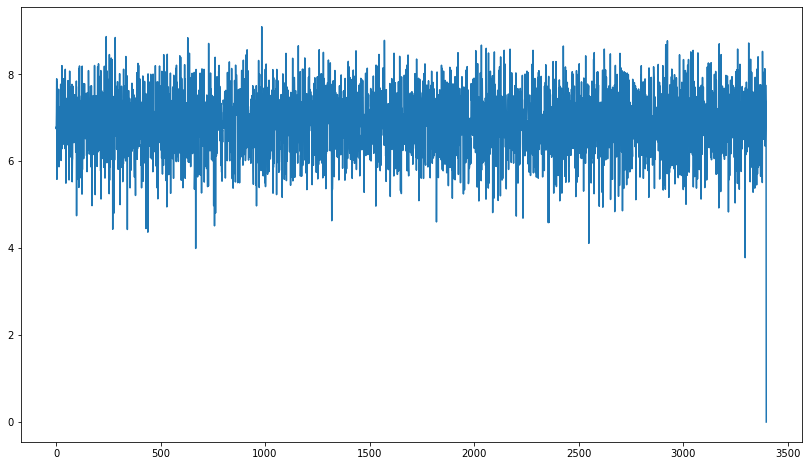

In [548]:
plt.figure(figsize=(14, 8))
plt.plot(sim)
plt.show()

In [643]:
TT = data_obj.dfs[5]['norm']

In [658]:
import DAMP_V2
reload(DAMP_V2)
from DAMP_V2 import DAMP_V2

In [659]:
damp = DAMP_V2({"lookahead": 100, "enable_output": True})

In [660]:
s_time = datetime.now()
scor, pos, left_MP = damp.DAMP_2_0(TT, 10, 100)
e_time = datetime.now()
d_time = e_time - s_time
print(f"Run time {d_time}")

-----------------------------------------------
Thank you for using DAMP.
This is version 2.0 of DAMP, please email Eamonn Keogh (eamonn@cs.ucr.edu) or Yue Lu (ylu175@ucr.edu) to make sure you have the latest version.
This time series is of length 3422, and the subsequence length is 10
The lookahead modified from 100 to the next power of 2: 128.
Hints:
Usually, the subsequence length you should use is between about 50 to 90% of a typical period.
A good initial value of lookahead is about 2^nearest_power_of_two(16 times S).
The range of lookahead should be 0 to length(T)-location_to_start_processing.
If speed is important, you can tune lookahead to get greater speed-up in your domain.
A simple search, doubling and halving the current value,
 should let you quickly converge on a good value.
------------------------------------------


Results:
Pruning Rate: 0.6335647449441594
Predicted discord score/position: 2.649722111273517 / [140]
Run time 0:00:44.885291


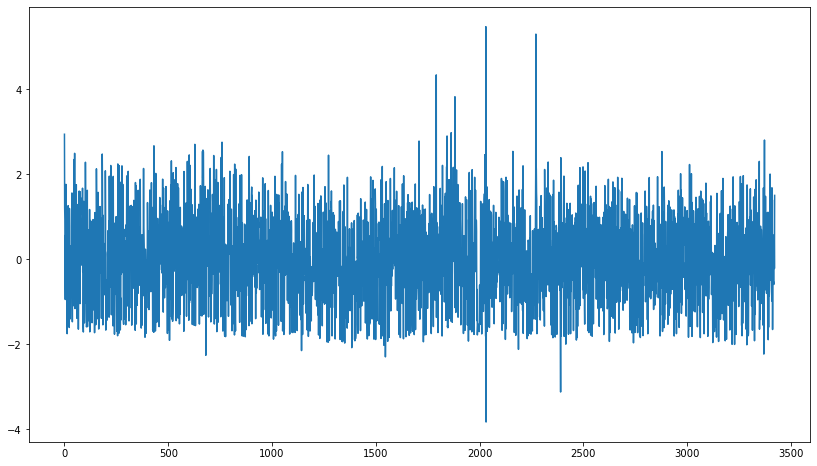

In [661]:
plt.figure(figsize=(14, 8))
plt.plot(TT)
plt.show()

In [663]:
len(left_MP)

3422

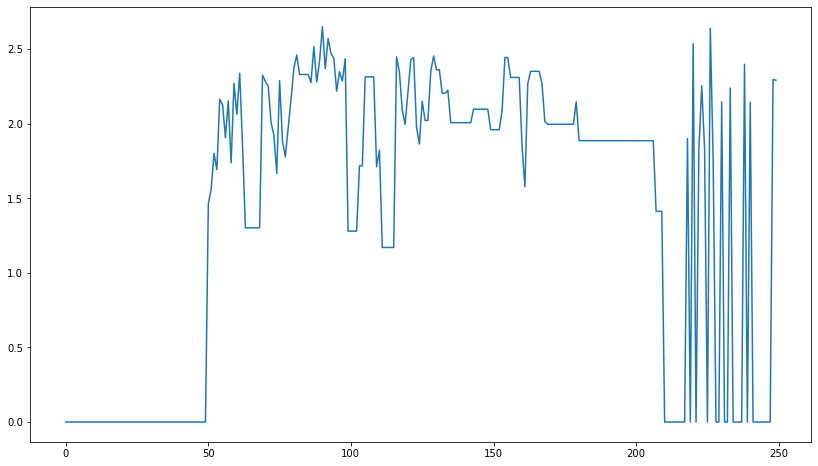

In [667]:
plt.figure(figsize=(14, 8))
plt.plot(left_MP[50:300])
plt.show()